<a href="https://colab.research.google.com/github/Emaan10/Elevvo-ML.internshipTasks/blob/main/Sales%20Forecasting/Elevvo_Task_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, shutil, warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

Download Dataset

In [ ]:
import kagglehub
path = kagglehub.dataset_download("aslanahmedov/walmart-sales-forecast")

DATA_DIR = "./data"
os.makedirs(DATA_DIR, exist_ok=True)

# Move files into ./data
for file in os.listdir(path):
    src = os.path.join(path, file)
    dst = os.path.join(DATA_DIR, file)
    if not os.path.exists(dst):
        shutil.copy(src, dst)

Load Data

In [ ]:
train = pd.read_csv("data/train.csv")
features = pd.read_csv("data/features.csv")
stores = pd.read_csv("data/stores.csv")

# Merge into one dataset
train = train.merge(features, on=["Store", "Date"], how="left")
train = train.merge(stores, on="Store", how="left")

# Convert Date column
train["Date"] = pd.to_datetime(train["Date"])
train = train.sort_values(["Store", "Date"]).reset_index(drop=True)

print("Dataset shape:", train.shape)
print(train.head())

Dataset shape: (421570, 17)
   Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     2 2010-02-05      50605.27        False        42.31       2.572   
2      1     3 2010-02-05      13740.12        False        42.31       2.572   
3      1     4 2010-02-05      39954.04        False        42.31       2.572   
4      1     5 2010-02-05      32229.38        False        42.31       2.572   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  211.096358   
1        NaN        NaN        NaN        NaN        NaN  211.096358   
2        NaN        NaN        NaN        NaN        NaN  211.096358   
3        NaN        NaN        NaN        NaN        NaN  211.096358   
4        NaN        NaN        NaN        NaN        NaN  211.096358   

   Unemployment  IsHoliday_y Type    Size  
0       

Feature Engineering

In [ ]:
train["Year"] = train["Date"].dt.year
train["Month"] = train["Date"].dt.month
train["Week"] = train["Date"].dt.isocalendar().week.astype(int)
train["Day"] = train["Date"].dt.day

train["rolling_7"] = train.groupby("Store")["Weekly_Sales"].transform(lambda x: x.rolling(7).mean())
train["rolling_14"] = train.groupby("Store")["Weekly_Sales"].transform(lambda x: x.rolling(14).mean())
train["rolling_30"] = train.groupby("Store")["Weekly_Sales"].transform(lambda x: x.rolling(30).mean())
train[["rolling_7", "rolling_14", "rolling_30"]] = train[["rolling_7", "rolling_14", "rolling_30"]].fillna(method='bfill')

for lag in [1, 2, 3]:
    train[f"lag_{lag}"] = train.groupby("Store")["Weekly_Sales"].shift(lag)
train = train.fillna(method="bfill")

Visualization

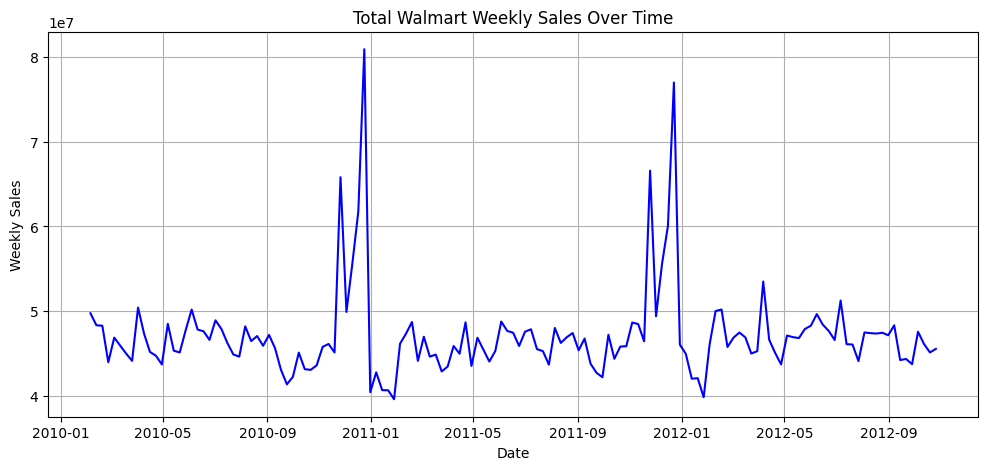

In [ ]:
daily_sales = train.groupby("Date")["Weekly_Sales"].sum()

plt.figure(figsize=(12, 5))
plt.plot(daily_sales.index, daily_sales.values, color='blue')
plt.title("Total Walmart Weekly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.show()

Seasonal Decomposition of Weekly Sales

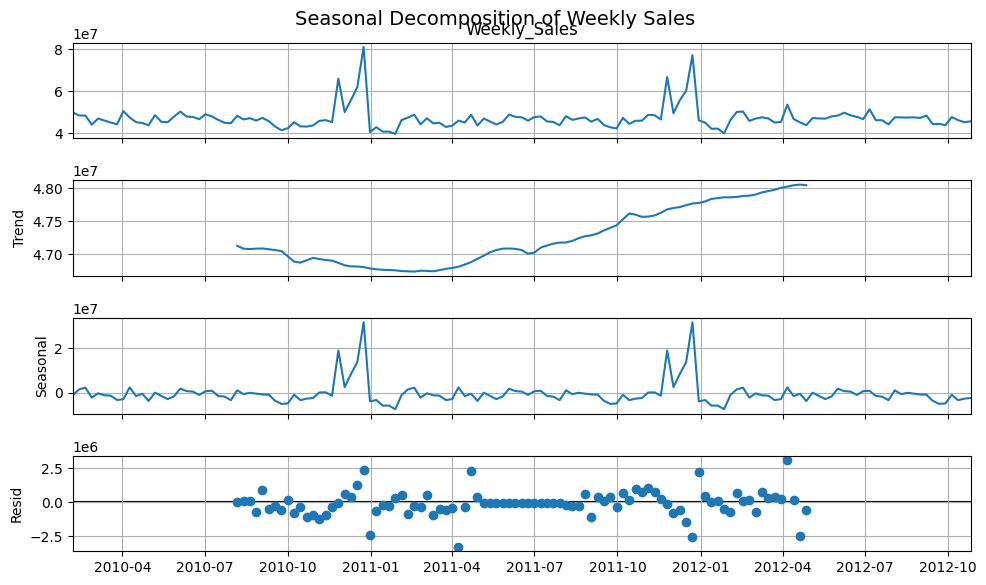

In [ ]:
decomposition = seasonal_decompose(daily_sales, model='additive', period=52)
fig = decomposition.plot()
fig.set_size_inches(10, 6)
plt.suptitle('Seasonal Decomposition of Weekly Sales', fontsize=14)
plt.show()

Train/Test Split

In [ ]:
X = train.drop(columns=["Weekly_Sales", "Date"])
y = train["Weekly_Sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Train/Test Split with Categorical Handling

In [ ]:
X = train.drop(columns=["Weekly_Sales", "Date"])
y = train["Weekly_Sales"]
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X = X.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Modeling

In [ ]:
models = {
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {"RMSE": rmse, "R2": r2}
    print(f"{name} → RMSE: {rmse:.2f}, R2: {r2:.4f}")

RandomForest → RMSE: 5882.62, R2: 0.9001
XGBoost → RMSE: 5100.38, R2: 0.9249
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4074
[LightGBM] [Info] Number of data points in the train set: 337256, number of used features: 26
[LightGBM] [Info] Start training from score 16794.267885
LightGBM → RMSE: 5135.35, R2: 0.9239


Actual vs Predicted Sales using RF & XGB

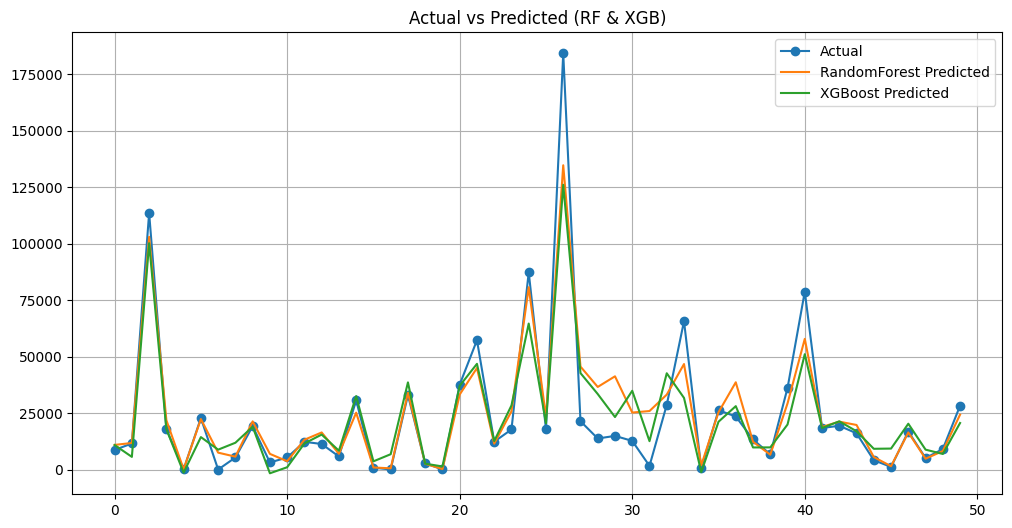

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:50], label='Actual', marker='o')

for name in ["RandomForest", "XGBoost"]:
    y_pred = models[name].predict(X_test)
    plt.plot(y_pred[:50], label=f'{name} Predicted')

plt.title("Actual vs Predicted (RF & XGB)")
plt.legend()
plt.show()

Actual vs Predicted Sales using LightGBM

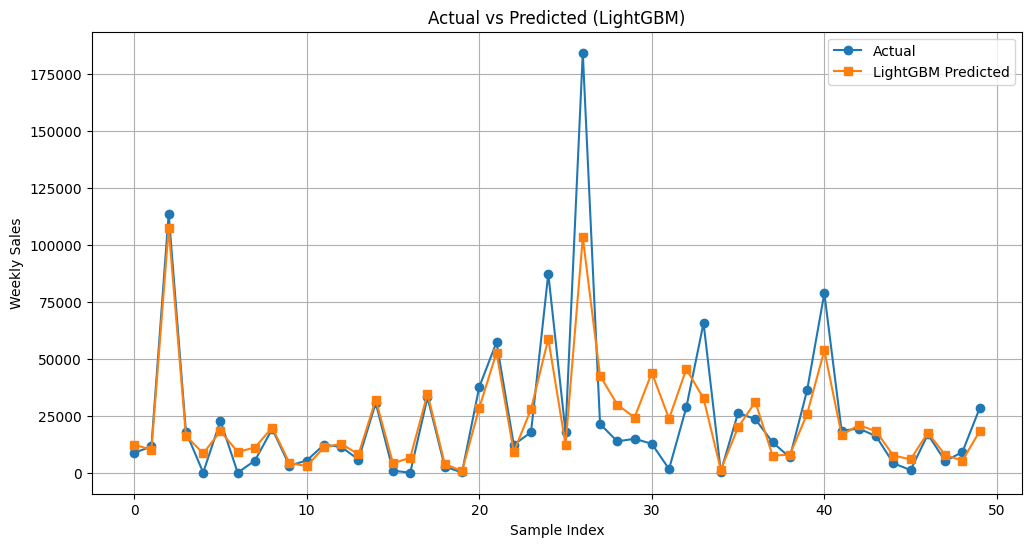

In [ ]:
if "LightGBM" in models:
    y_pred_lgb = models["LightGBM"].predict(X_test)

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values[:50], label='Actual', marker='o')
    plt.plot(y_pred_lgb[:50], label='LightGBM Predicted', marker='s')
    plt.title("Actual vs Predicted (LightGBM)")
    plt.xlabel("Sample Index")
    plt.ylabel("Weekly Sales")
    plt.legend()
    plt.show()

Model Performance Evaluation using MSE and R² Score

In [ ]:
if "RandomForest" in models:
    y_pred = models["RandomForest"].predict(X_test)
else:
    first_model = list(models.keys())[0]
    y_pred = models[first_model].predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

MSE: 34605271.48390185
R2 Score: 0.9001177549698561


Visualization of Final Model Predictions vs Actual Sales

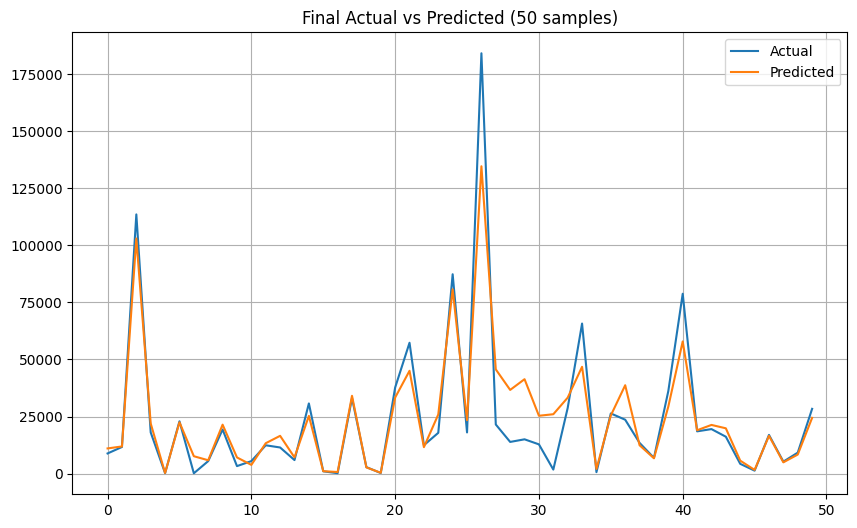

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values[:50], label='Actual')
plt.plot(y_pred[:50], label='Predicted')
plt.legend()
plt.title("Final Actual vs Predicted (50 samples)")
plt.show()